# Sumarise clinical features & case mutations / molecular phenotypes.

Here we want to sumarise some of the major clinical features.

### Demographics
- Race demographics (ethnicity_self_identified)
- Age (age) --> separate into young (< 50) mid (50 - 70), old (> 70)?
- BMI (BMI) --> separate into underweight (< 19) normal (19 - 25), pre-obese (26-30), obsesity class 1 (30 - 35), obesisty class 2 (35 - 40), obesity class 3) (41 - 49
- tumour stage (tumor_stage_pathological)
- tumour size (tumor_size_in_cm)
- white cell count (white_cell_count)  
- vital status (vital_status_at_12months_follow_up)


### Mutations
    - MTOR (5)
    - TP53 (6)
    - SETD2 (11)
    - BAP1 (14)
    - KDM5C (16)
    - PBRM1 (37)
    - VHL (73)
    - TTN (21)
    - CUBN (10)
    - BRCA2 (3)
    
### Molecular phenotypes
Here we have: 
- CIMP+ or CIMP-  
- Stable or unstable. 

### Clinical information

Downloaded information from (metadata files).
https://cptac-data-portal.georgetown.edu/study-summary/S050

Couldn’t find matching patient names between the clinical attributes in the protein data so had to down load the data from: https://cptac-data-portal.georgetown.edu/study-summary/S044


In [1]:
import pandas as pd
base_dir = '../data/'
data_dir = f'{base_dir}raw_downloads/CPTAC/'
output_dir = f'{base_dir}sircle/F1_DE_input_TvN/'
# First we need to get demographic info from the clinical DF
clin_df = pd.read_csv(f'{data_dir}Patient_Clinical_Attributes.csv')
clin_mod_df = pd.DataFrame()

case_id = 'case_id'
gender = 'gender'
age = 'age'
age_grp = 'AgeGrouped'
race_grp = 'RaceGrouped'
bmi = 'BMI'
bmi_grp = 'BMIGrouped'
race = 'ethnicity_self_identified'
t_stage = 'tumor_stage_pathological'
t_size = 'tumor_size_in_cm'
cell_count = 'white_cell_count'
status = 'vital_status_at_12months_follow_up'

# Add in the base info to the our version of the clin df
clin_mod_df[case_id] = clin_df[case_id].values
clin_mod_df[gender] = clin_df[gender].values
clin_mod_df['TumorStage'] = clin_df[t_stage].values

age_grps = []
for a in clin_df[age]:
    if a == '>=90':
        age_grps.append('old')
    elif int(a) < 42:
        age_grps.append('young')
    elif int(a) < 58:
        age_grps.append('middle')
    elif int(a) < 90:
        age_grps.append('old')
    else:
        print(a)

bmi_grps = []
for a in clin_df[bmi]:
    if int(a) < 19:
        bmi_grps.append('underweight')
    elif int(a) < 25:
        bmi_grps.append('normal')
    elif int(a) < 30:
        bmi_grps.append('pre-obese')
    elif int(a) < 35:
        bmi_grps.append('obese-1')
    elif int(a) < 40:
        bmi_grps.append('obese-2')
    elif int(a) < 70:
        bmi_grps.append('obese-3')
    else:
        print('BMI', a)
        
bmi_grps = []
for a in clin_df[bmi]:
    if int(a) < 19:
        bmi_grps.append('normal')
    elif int(a) < 25:
        bmi_grps.append('normal')
    elif int(a) < 30:
        bmi_grps.append('between')
    elif int(a) < 35:
        bmi_grps.append('between')
    elif int(a) < 40:
        bmi_grps.append('obese')
    elif int(a) < 70:
        bmi_grps.append('obese')
    else:
        print('BMI', a)
clin_mod_df[age_grp] = age_grps
clin_mod_df[bmi_grp] = bmi_grps

# Make the race groups simplified
race_grp = 'RaceGrouped'
race_grps = []
for r in clin_df[race]:
    if r == 'Caucasian' or r == 'White' or r == 'American':
        race_grps.append('White')
    elif r == 'Slavonic':
        race_grps.append('Slavonic')
    elif r == 'Medical record does not state' or r == 'Patient not interviewed':
        race_grps.append('NA')
    elif r == 'Hispanic':
        race_grps.append('Hispanic')
    else:
        race_grps.append('Asian')
        print(r)
        
clin_mod_df[race_grp] = race_grps

# Print out the different groups
demo_cols = [age_grp, bmi_grp, race_grp, gender]
for d in demo_cols:
    print(clin_mod_df[d].value_counts())

Asian
Vietnam
Asian
Asian
Indian
old       66
middle    35
young      9
Name: AgeGrouped, dtype: int64
between    56
obese      33
normal     21
Name: BMIGrouped, dtype: int64
White       78
NA          12
Slavonic    11
Asian        5
Hispanic     4
Name: RaceGrouped, dtype: int64
Male      80
Female    30
Name: gender, dtype: int64


### Mutations

First we need to download all the mutations and make a dataframe based on these (only needs to be done once).

Then we want to look at all the different mutations and annote these to cases.

In [2]:
"""
We only want to do this once I keep it off by default :) 
"""
# Download mutation data
# Here we want to download the mutation files
from scidat.download import Download
from sciutil import SciUtil

supp_dir = f'{base_dir}raw_downloads/supps/' # Where you need to put the GDC client
u = SciUtil()

case_ids = list(set(clin_mod_df[case_id].values))

download_mutation = False
if download_mutation:

    download = Download(f'{data_dir}RNA_clinical.csv', 
                        f'{data_dir}mutations/', 
                        f'{data_dir}mutations/', 
                        f'{supp_dir}gdc-client', 
                        max_cnt=1)
    download.download_data_using_api(case_ids, 'mutation')
else:
    u.dp(["You said you already have your mutations downloaded, if this isn't the case you'll need to do this!"])


--------------------------------------------------------------------------------
You said you already have your mutations downloaded, if this isn't the case you'll need to do this!	
--------------------------------------------------------------------------------


In [3]:
# Set up the mutation stuff (already downloaded mutation info in the processing dir)
from scidat.api import API, APIException

tcga_data_dir = f'{base_dir}raw_downloads/TCGA/'
gdc_client = f'{tcga_data_dir}./gdc-client'
sample_file = f'{tcga_data_dir}gdc_sample_sheet.2021-05-03.tsv'
manifest_file = f'{tcga_data_dir}gdc_manifest_20210503_065756.txt'
annotation_file = f'{supp_dir}hsapiens_gene_ensembl-GRCh38.p13.csv'
clinical_file = f'{tcga_data_dir}clinical.cart.2021-05-03/clinical.tsv'

api = API(manifest_file, gdc_client, clinical_file, sample_file, data_dir, data_dir, annotation_file,
                            max_cnt=10, requires_lst=['counts'])

mutation_dir = f'{data_dir}mutations/'
api.build_mutation_df(mutation_dir)

# Now we want to build a dictionary with mutations and cases.
filter_col = 'ssm.consequence.0.transcript.gene.symbol'
genes_with_mutations = api.get_mutation_values_on_filter('ssm.consequence.0.transcript.gene.symbol', [''], 'ssm.consequence.0.transcript.gene.symbol')

# Now for each gene we want to count the patients with mutations
cases_w_mutations = {}
for g in genes_with_mutations:
    cases = api.get_mutation_values_on_filter('case_id', [g], filter_col, exact=True)
    cases_w_mutations[g] = cases


# Sort keys by the genes with most mutations
sorted_genes_w_mutations = sorted(cases_w_mutations, key=lambda k: len(cases_w_mutations[k]), reverse=True)

# Print these out!
for g in sorted_genes_w_mutations:
    print(g, len(cases_w_mutations[g]))

VHL 73
PBRM1 37
TTN 21
KDM5C 16
BAP1 14
MUC16 12
CSMD3 12
SETD2 11
USH2A 10
CUBN 10
MALAT1 8
TNRC18 8
BIRC6 7
RELN 7
SYNE1 7
MACF1 7
LRP2 7
CCDC168 6
RSF1 6
PCLO 6
TP53 6
DST 6
KIF1B 6
MYO16 5
OPTN 5
PKHD1 5
ARHGAP32 5
SVEP1 5
NEB 5
SYNE2 5
HSPA8 5
XIRP2 5
HECW1 5
TNKS 5
PCDHB6 5
PIKFYVE 5
PCDH15 5
CSMD2 5
ADAMTS20 5
PITPNM2 5
PTEN 5
MUC17 5
GOLGB1 5
YLPM1 5
RYR2 5
FAT2 5
MTOR 5
FCGBP 5
OBSCN 5
KMT2C 5
HMCN1 5
VAPB 5
ANK3 5
RPRD2 5
FAT1 5
EXPH5 4
SMG1 4
SYCP2L 4
PCDH20 4
NAV3 4
ITGA3 4
USP34 4
ABCC12 4
KIAA0100 4
NELL2 4
ZNF91 4
GLI2 4
DYNC1H1 4
UNC13B 4
PPWD1 4
KCNH5 4
ZACN 4
TTC3 4
LAMB4 4
SLC4A4 4
CACNA1F 4
CACNA1H 4
HECTD4 4
KCNA4 4
DGKZ 4
CHD3 4
IGKC 4
LAMA2 4
PHTF1 4
MON2 4
FSIP2 4
RNF213 4
RPS6KC1 4
FAM179B 4
AHCTF1 4
PTPRK 4
TERT 4
COL22A1 4
PCDH7 4
TMEM108 4
KDM2B 4
MYO15A 4
VPS13D 4
ANKRD26 4
NLRP12 4
TNC 4
RALGAPB 4
NOTCH3 4
AUTS2 4
POM121 4
SPEG 4
CAND1 4
SF3B1 4
EPHB2 4
ACACA 4
MALRD1 4
WWC3 4
CHD9 4
MAPT 4
GREB1 4
CHUK 4
KIAA1109 4
DNAH3 4
ZNF292 4
RAD54L 4
AKAP13 4
ASTN1

PARP9 1
MEN1 1
CFAP58 1
MYBPC3 1
USP6NL 1
TRIM60 1
TMC4 1
SPDYC 1
GFI1 1
LHX5 1
FLVCR2 1
OR9A4 1
RBM4B 1
MERTK 1
RIC8A 1
CPPED1 1
CDC37 1
CHST3 1
MRPL48 1
FGFR4 1
STXBP1 1
POU3F3 1
SRRT 1
NUP210L 1
MBTPS2 1
MTERF4 1
AMH 1
AC092675.3 1
FLT3 1
CNOT11 1
MAPK8IP3 1
TMPRSS13 1
C4orf17 1
LYPLA2P2 1
FOXM1 1
SLC4A9 1
RGS12 1
ADIRF 1
MEIS3 1
ERLIN2 1
KIT 1
CBX2 1
SOCS5 1
SPRED1 1
MAPK9 1
IGHA1 1
C11orf30 1
SETDB1 1
ATP10A 1
NXPH4 1
NUP210 1
RBM47 1
PDLIM7 1
ABHD17C 1
PDCL3 1
HTR5A 1
DEFB134 1
ACSS1 1
ATAD3C 1
TGFBR3 1
FAM53B 1
ZNF92 1
TCHH 1
PLIN1 1
SEC1P 1
LZTR1 1
KRBA2 1
DNM2 1
CCDC170 1
KLHL33 1
PARD3B 1
MFGE8 1
ACAA1 1
LHX3 1
AKNAD1 1
NHEJ1 1
LRP5 1
NUP93 1
RNF138 1
IGKV1-27 1
UBXN4 1
NCKAP1 1
SDCCAG8 1
LAMB1 1
TSC1 1
IRF7 1
RHOXF2 1
TMEM239 1
STK38 1
CCDC129 1
YJEFN3 1
ALKBH6 1
KDR 1
ADRBK1 1
VSIG10L 1
BTF3L4 1
GLT8D2 1
ULK2 1
PPP4R1L 1
PMPCB 1
CMPK2 1
RTN4R 1
ATP6V0A1 1
TBX2 1
OTUD6A 1
RPSA 1
PPP1R16A 1
RANBP9 1
NELL1 1
C4orf36 1
FAM228A 1
THBS2 1
TUBB4B 1
PCSK1 1
DPH1 1
TCEB1 1
MDM4 1
NP

ECI2 1
VPRBP 1
CNNM2 1
CLUL1 1
SYCE1L 1
ZYG11B 1
FAM9A 1
SMTN 1
ARL6IP5 1
DOCK9 1
WDR61 1
OR9G1 1
TCL1A 1
OR5T3 1
SKIV2L 1
OR4S2 1
DNAJB13 1
COL5A3 1
ALG10 1
PGRMC1 1
CDC16 1
TMEM145 1
ARID1A 1
PLCD4 1
LCE3A 1
HS3ST3B1 1
NEU1 1
LANCL3 1
LPAR6 1
ZFAND4 1
CYP2E1 1
BIVM-ERCC5 1
FRRS1L 1
RP11-96P7.1 1
CTC-512J12.6 1
PRF1 1
CAPN8 1
SMPDL3A 1
TMEM68 1
TMC2 1
N4BP1 1
UBE2D2 1
GTF3C3 1
ERH 1
DDR2 1
FMO5 1
KANSL2 1
MAP3K14 1
KAT2A 1
PRIMA1 1
TMEM59 1
JAM2 1
HPSE2 1
ADAM23 1
PTPN5 1
ARHGEF2 1
G2E3 1
RPL14 1
DYRK3 1
IFIT3 1
ZNF213 1
EIF2AK1 1
C22orf34 1
ARAP2 1
RIBC1 1
ZNF546 1
LONRF2 1
USP6 1
CSN2 1
SDF4 1
C5orf56 1
UBE2L3 1
PDPK1 1
BTBD18 1
LONRF3 1
LRRC8D 1
KIAA1841 1
TJP3 1
KCND3 1
GNGT1 1
ATP5B 1
HSF4 1
LRCOL1 1
SLC2A4RG 1
DDX50 1
GPATCH2 1
SH3D21 1
HOXA1 1
GRIK2 1
STIM1 1
KIAA0930 1
SUSD4 1
KHK 1
SP100 1
PAPOLA 1
FHL1 1
SUSD6 1
CD72 1
S100A10 1
ORMDL2 1
GABRR2 1
KRT7 1
PRG4 1
KLHL36 1
KATNAL1 1
TNS4 1
GMEB2 1
CCM2 1
HHLA1 1
TTI1 1
FAM227B 1
RGS6 1
DDX59 1
SSUH2 1
ST5 1
MFI2 1
PRRT1 1
SNRNP2

CHRD 1
UBR7 1
PLG 1
FNIP1 1
WBSCR28 1
OR5I1 1
ECD 1
NCAM2 1
RAB4A 1
GART 1
RAF1 1
PARS2 1
CNOT7 1
HEY1 1
MED30 1
IL32 1
CCDC146 1
TBC1D10A 1
VSTM2A 1
C11orf96 1
GRAMD1C 1
PPP1R26 1
AP1M1 1
ATP2A1 1
LRRC28 1
HOXC5 1
ZBTB49 1
TYK2 1
PIAS4 1
SLC12A3 1
FBXO38 1
TMEM184B 1
CSNK1D 1
KIF12 1
CSF2RA 1
MPDU1 1
PLCL2 1
MRGPRG 1
ABCC11 1
ATG4B 1
ZNF829 1
TMUB1 1
DCAF15 1
ATXN7L3 1
S100A1 1
LYN 1
ATP8A1 1
PDX1 1
LMOD1 1
PPP6R2 1
FNTA 1
IMMP2L 1
CCDC106 1
PCSK7 1
ANK1 1
IL17RD 1
OR2L3 1
PHLDA1 1
MUTYH 1
CCDC65 1
ABCA3 1
GSTA2 1
KIAA1875 1
SLC16A4 1
NUFIP2 1
BCL11A 1
APTX 1
BMX 1
SMAD4 1
HERC3 1
UNC13A 1
TMEM208 1
GSTO1 1
COMMD6 1
ATF7IP 1
HERC1 1
MTRF1L 1
RBBP7 1
ARHGEF17 1
DBP 1
TEAD1 1
TTC39B 1
EPB41L1 1
DCLRE1B 1
LIPC 1
INO80D 1
TBC1D2 1
OTUD5 1
SLC9A4 1
IGSF1 1
CTCF 1
ZNF224 1
MCTP1 1
TCP10L 1
OR5K2 1
NDST2 1
ZFAT 1
ZFC3H1 1
FTCD 1
CLCA4 1
KIF1A 1
ARHGEF18 1
LTBP1 1
TDP1 1
SBK1 1
ADGRE5 1
USP17L1 1
HIST1H3A 1
NTF3 1
STK10 1
ZNF140 1
MEGF11 1
SFTPB 1
STX17 1
FAM21C 1
SLC27A3 1
DKFZp313A047 1
PRP

## Check if FBP1 in mutations

In [4]:
[g for g in sorted_genes_w_mutations if g == 'FBP1'] # Not in if it is empty

[]

# Plot the number of mutations and distribution

Text(0.5, 1.0, 'Number of cases with a given mutation')

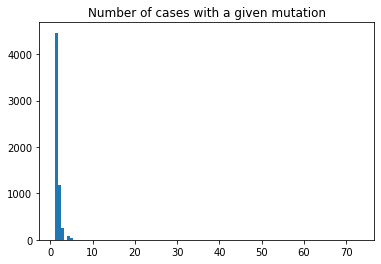

In [5]:
mutations_c = []
for gene in cases_w_mutations:
    mutations_c.append(len(cases_w_mutations[gene]))
    
import matplotlib.pyplot as plt
plt.hist(mutations_c, bins=100)
plt.title('Number of cases with a given mutation')

In [6]:
case_to_mutation = {}
for gene in cases_w_mutations:
    if len(cases_w_mutations[gene]) > 10:
        for c in cases_w_mutations[gene]:
            if case_to_mutation.get(c):
                case_to_mutation[c].append(gene)
            else:
                case_to_mutation[c] = [gene]
                
# Check how many patients only have one mutation
number_mutations = []
for c in case_to_mutation:
    number_mutations.append(len(case_to_mutation[c]))
    
# plt.hist(number_mutations, bins=20)
# plt.title("Number of mutations per case (if gene has 5 or more cases)")

## Get cases with specific mutations only

In [7]:
for c in case_to_mutation:
    if len(case_to_mutation[c]) == 1:
        print(case_to_mutation[c])

['PBRM1']
['PBRM1']
['PBRM1']
['PBRM1']
['PBRM1']
['TTN']
['TTN']
['MUC16']
['MUC16']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['VHL']
['BAP1']
['CSMD3']


## Visualise the mutation DFs



In [8]:
import numpy as np

# We need to read in the RNAseq dataframe (we read in the normalised counts Dataframe)
rna_df = pd.read_csv(f'{output_dir}CCRCC_Clark_Cell2019_rna_filtered_df.csv')
for c in rna_df.columns:
    if 'CPT' in c:
        rna_df[c] = np.log2(rna_df[c].values + 1)
gene_name = 'external_gene_name'

def plt_top_genes(rna_df, muts, cases_wo_muts, label='', gender='', n_genes=20):
    cols = [gene_name]
    for c in muts:
        for cd in rna_df.columns:
            if 'CPTAC' in cd and cd.split('_')[-2] == c:
                cols.append(cd)
                break
    c_i = 0
    for c in cases_wo_muts:
        for cd in rna_df.columns:
            if 'CPTAC' in cd and cd.split('_')[-2] == c and 'PrimaryTumor' in cd:
                cols.append(cd)
                c_i += 1
                break
        if c_i == len(muts):
            break

    cond_df = rna_df[cols].copy()
    values = cond_df[cols[1:]]
    var_vals = np.var(values, axis=1)
    cond_df['Variance'] = var_vals
    ko = cols[1:len(muts) + 1]
    wt = cols[len(muts) + 1:len(cond_df.columns)]
    change_v = np.mean(cond_df[ko].values, axis=1) - np.mean(cond_df[wt].values, axis=1)
    cond_df['mean_c'] = change_v
    col_colours = [len(wt) * ['r'] + len(ko) * ['b']]
    
    var_b = cond_df.nlargest(n_genes, 'mean_c')
    heatmap = Heatmap(var_b, cols[1:], gene_name, f'Largest genes {label}', '', col_colours=col_colours, label_font_size=12, figsize=(6, 5), linewidths=0.5, x_tick_labels=0, cluster_cols=False)
    heatmap.plot()
    plt.show()

    var_b = cond_df.nsmallest(n_genes, 'mean_c')
    heatmap = Heatmap(var_b, cols[1:], gene_name, f'Largest genes {label}', '', col_colours=col_colours, label_font_size=12, figsize=(6, 5), linewidths=0.5, x_tick_labels=0, cluster_cols=False)
    heatmap.plot()
    plt.show()

In [9]:
import numpy as np
genes_of_interest = ['MTOR', 'VHL', 'SETD2', 'PBRM1', 'KDM5C', 'TTN', 'BAP1']
mutations_to_cases = {}
all_cases_w_muts = []
for g in genes_of_interest:
    mutations_to_cases[g] = api.get_mutation_values_on_filter('case_id', [g], filter_col, exact=True)
    all_cases_w_muts += mutations_to_cases[g]
    
# Keep track of the cases without mutations
all_cases = clin_df[case_id].values
cases_wo_muts = [c for c in all_cases if c not in all_cases_w_muts]


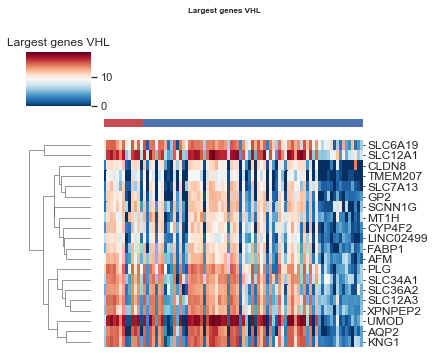

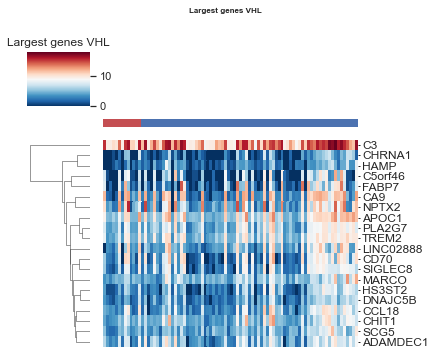

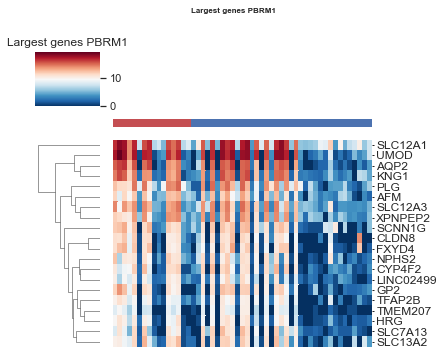

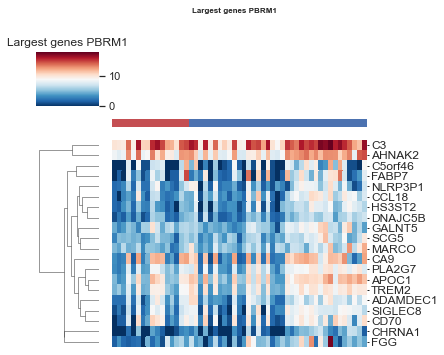

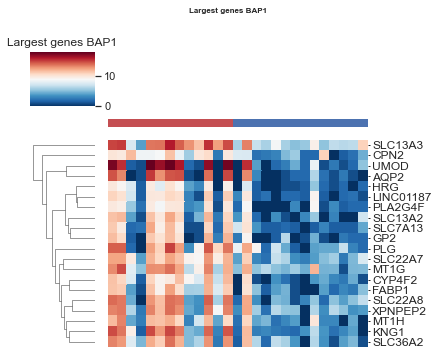

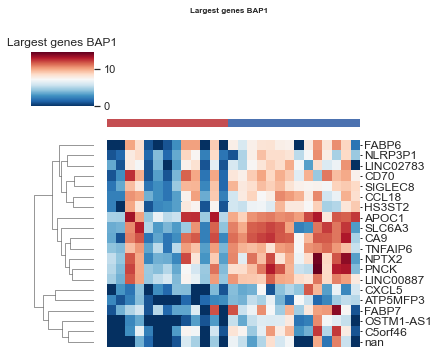

In [11]:
from sciviso import Heatmap

genes_of_interest = ['VHL', 'PBRM1', 'BAP1']

for g in genes_of_interest:
    plt_top_genes(rna_df, mutations_to_cases[g], cases_wo_muts, label=g, gender='', n_genes=20)


In [21]:
## Finally let's add a column to our clinical DF for each of the mutations
genes_of_interest = ['MTOR', 'VHL', 'SETD2', 'PBRM1', 'KDM5C', 'TTN', 'BAP1']

for g in genes_of_interest:
    mutation_col = []
    for case in clin_mod_df[case_id].values:
        if case in mutations_to_cases[g]:
            mutation_col.append(1) # has mutation
        else:
            mutation_col.append(0)
    clin_mod_df[f'{g}_mutation'] = mutation_col

In [23]:
# Check if BAP1 or PBMR1 occur at the same time
[c for c, v in case_to_mutation.items() if 'PBRM1' in v and 'BAP1' in v]

[]

## Add molecular classes as well

In [25]:
mol_class_df = pd.read_csv(f'{data_dir}CIMP-status_Chr-stability_supp-download.csv')
cimp_pos = mol_class_df[mol_class_df['CIMP status'] == 'CIMP+']['Case ID'].values
unstable = mol_class_df[mol_class_df['Genome instability'] != 'Stable']['Case ID'].values
cimp_values = []
stability_values = []
for case in clin_mod_df[case_id].values:
    if case in cimp_pos:
        cimp_values.append(1)  # Is CIMP pos
    else:
        cimp_values.append(0)
    # Check stability
    if case in unstable:
        stability_values.append(1)
    else:
        stability_values.append(0)

clin_mod_df['CIMPStatus'] = cimp_values
clin_mod_df['GenomeInstability'] = stability_values
# Make R friendly cases (they don't like -)
clin_mod_df['SafeCases'] = [c.replace('-', '.') for c in clin_mod_df['case_id'].values]
clin_mod_df.set_index('SafeCases', inplace=True)

In [26]:
clin_mod_df.to_csv(f'{output_dir}clinical_sircle_13052022.csv')

## Create groupings of patients

We're interested in how having groups of patients with the following 5 mutation "patterns":
1) VHL+TTN  
2) VHL-TTN  
3) VHL+PBRM1  
4) VHL-PBRM1  
5) PBRM1-VHL  

In [27]:
vhl_and_ttn = [c for c, v in case_to_mutation.items() if 'VHL' in v and 'TTN' in v]
vhl_no_ttn = [c for c, v in case_to_mutation.items() if 'VHL' in v and 'TTN' not in v]
vhl_and_pbrm1 = [c for c, v in case_to_mutation.items() if 'VHL' in v and 'PBRM1' in v]
vhl_no_pbrm1 = [c for c, v in case_to_mutation.items() if 'VHL' in v and 'PBRM1' not in v]
pbrm1_no_vhl = [c for c, v in case_to_mutation.items() if 'VHL' not in v and 'PBRM1' in v]
vhl = [c for c, v in case_to_mutation.items() if 'VHL' in v and 'PBRM1' not in v and 'TTN' not in v]
ttn_no_vhl = [c for c, v in case_to_mutation.items() if 'VHL' not in v and 'TTN' in v]
vhl_ttn_pbrm1 = [c for c, v in case_to_mutation.items() if 'VHL' not in v and 'TTN' in v and 'PBRM1' in v]

pbrm1 = [c for c, v in case_to_mutation.items() if 'PBRM1' in v]
bap1 = [c for c, v in case_to_mutation.items() if 'BAP1' in v]



In [28]:
def add_lbl(case_lst, label_name, df):
    cases = [1 if case in case_lst else 0 for case in df['case_id'].values]
    df[label_name] = cases
    return df


In [32]:
clin_comb = add_lbl(vhl_and_ttn, 'VHL+TTN', clin_mod_df)
clin_comb = add_lbl(vhl_no_ttn, 'VHL-TTN', clin_comb)
clin_comb = add_lbl(vhl_and_pbrm1, 'VHL+PBRM1', clin_comb)
clin_comb = add_lbl(vhl_no_pbrm1, 'VHL-PBRM1', clin_comb)
clin_comb = add_lbl(pbrm1_no_vhl, 'PBRM1-VHL', clin_comb)
clin_comb = add_lbl(vhl, 'VHL', clin_comb)
clin_comb = add_lbl(ttn_no_vhl, 'TTN-VHL', clin_comb)
clin_comb = add_lbl(vhl_ttn_pbrm1, 'TTN+PBRM1-VHL', clin_comb)
clin_comb = add_lbl(bap1, 'BAP1_mutation', clin_comb)
clin_mod_df = clin_comb # Easier for lower down

In [30]:
clin_comb.to_csv(f'{output_dir}clinical_sircle.csv', index=False)

In [33]:
clin_comb

,case_id,gender,TumorStage,AgeGrouped,BMIGrouped,RaceGrouped,MTOR_mutation,VHL_mutation,SETD2_mutation,PBRM1_mutation,...,CIMPStatus,GenomeInstability,VHL+TTN,VHL-TTN,VHL+PBRM1,VHL-PBRM1,PBRM1-VHL,VHL,TTN-VHL,TTN+PBRM1-VHL
SafeCases,,,,,,,,,,,,,,,,,,,,,
C3L.00004,C3L-00004,Male,Stage III,old,normal,White,0,1,1,1,...,1,0,0,1,1,0,0,0,0,0
C3L.00010,C3L-00010,Male,Stage I,young,between,White,0,1,0,0,...,0,0,0,1,0,1,0,1,0,0
C3L.00011,C3L-00011,Female,Stage IV,old,between,White,0,1,0,0,...,1,1,1,0,0,1,0,0,0,0
C3L.00026,C3L-00026,Female,Stage I,old,between,White,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
C3L.00079,C3L-00079,Male,Stage III,middle,obese,White,0,1,0,0,...,1,1,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N.01646,C3N-01646,Male,Stage III,old,between,White,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
C3N.01648,C3N-01648,Male,Stage II,old,between,White,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C3N.01649,C3N-01649,Male,Stage III,middle,obese,White,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


### Adding numbers for Alluvial plot
Here we want to add the numbers to be able to understand how the patients flow through 
the alluvial plot.

In [34]:
import pandas as pd

# Stages are stage 1 or other stages
# Want to go through all the mutations (i.e. select the rows with 1 in that column)
ages = ['young' ,'middle', 'old']
cimps = [1, 0]
mutations = [c for c in clin_mod_df.columns if 'mutation' in c]
mutations

['MTOR_mutation',
 'VHL_mutation',
 'SETD2_mutation',
 'PBRM1_mutation',
 'KDM5C_mutation',
 'TTN_mutation',
 'BAP1_mutation']

(array([ 3.,  8.,  8., 24., 20., 21., 12.,  9.,  2.,  3.]),
 array([  0. ,  16.3,  32.6,  48.9,  65.2,  81.5,  97.8, 114.1, 130.4,
        146.7, 163. ]),
 <BarContainer object of 10 artists>)

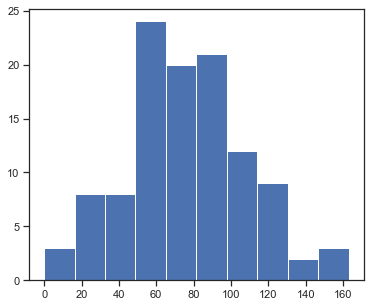

In [35]:
import matplotlib.pyplot as plt

mutations = ['VHL_mutation',
             'PBRM1_mutation',
             'TTN_mutation',
             'KDM5C_mutation',
             'MTOR_mutation',
             'BAP1_mutation',
             'SETD2_mutation']

clin_alluvial_df = pd.DataFrame()
cimps = []
for c in clin_mod_df['CIMPStatus'].values:
    if c == 1:
        cimps.append('+')
    else:
        cimps.append('-')

clin_alluvial_df['Stage'] = clin_mod_df['TumorStage'].values
clin_alluvial_df['Age'] = clin_mod_df['AgeGrouped'].values
clin_alluvial_df['CIMP'] = cimps
clin_alluvial_df['BMI'] = clin_mod_df['BMIGrouped'].values
clin_alluvial_df['Race'] = clin_mod_df['RaceGrouped'].values

for m in mutations:
    mod = []
    for c in clin_mod_df[m].values:
        if c == 1:
            mod.append('Y')
        else:
            mod.append('N')
    clin_alluvial_df[m.split('_')[0]] = mod

case_mutation_count = []
for c in clin_mod_df['case_id'].values:
    case_count = 0
    for gene, cases in cases_w_mutations.items():
        if c in cases:
            case_count += 1
    case_mutation_count.append(case_count)

plt.hist(case_mutation_count)

In [36]:
mutations_simple = []
for m in case_mutation_count:
    if m < 20:
        mutations_simple.append('<20')
    elif m < 40:
        mutations_simple.append('20-40')
    elif m < 60:
        mutations_simple.append('40-60')
    elif m < 80:
        mutations_simple.append('60-80')
    elif m < 100:
        mutations_simple.append('80-100')
    elif m < 120:
        mutations_simple.append('100-120')
    else:
        mutations_simple.append('>120')
clin_alluvial_df['Mutation count'] = mutations_simple


In [37]:
cols = ['TumorStage', 'AgeGrouped', 'CIMPStatus'] + mutations
cols = list(clin_alluvial_df.columns)
alluvial_2 = clin_alluvial_df.groupby(['Stage', 'Age', 'CIMP', 'VHL', 'PBRM1', 'TTN',
       'SETD2', 'BAP1', 'MTOR', 'KDM5C', 'Mutation count'],as_index=False).size()# clin_mod_df.groupby(cols,as_index=False).size()

In [38]:
alluvial_2.to_csv(f'{output_dir}alluvial_age_cimp_stage_mutations-grouped.csv', index=False)